<a href="https://colab.research.google.com/github/parment1/Project-M1-M2/blob/main/Pair_trading_clusters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
#pip install yahoo_fin
import yahoo_fin.stock_info as si
import missingno
import pandas as pd
import pytz
import empyrical
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline
from kneed import KneeLocator
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc
from itertools import cycle
from statsmodels.tsa.stattools import coint
from sklearn.manifold import TSNE
import matplotlib.cm as cm
from sklearn.metrics import silhouette_score


In [8]:
sp500_list = si.tickers_sp500()
print("Number of Tickers in S&P 500:", len(sp500_list))
sp500_list[0:5]

Number of Tickers in S&P 500: 505


['A', 'AAL', 'AAP', 'AAPL', 'ABBV']

In [9]:
sp500_historical = {}
for ticker in sp500_list:
    sp500_historical[ticker] = si.get_data(ticker, start_date="01/01/2019", index_as_date = False, interval="1d")
sp500_historical

/usr/local/lib/python3.7/dist-packages/yahoo_fin/stock_info.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame['ticker'] = ticker.upper()


{'A':           date        open        high  ...    adjclose   volume  ticker
 0   2019-01-02   66.500000   66.570000  ...   64.346901  2113300       A
 1   2019-01-03   65.529999   65.779999  ...   61.976398  5383900       A
 2   2019-01-04   64.089996   65.949997  ...   64.121628  3123700       A
 3   2019-01-07   65.639999   67.430000  ...   65.483215  3235100       A
 4   2019-01-08   67.589996   68.209999  ...   66.443176  1578100       A
 ..         ...         ...         ...  ...         ...      ...     ...
 727 2021-11-18  162.529999  162.820007  ...  162.160004  1475800       A
 728 2021-11-19  163.009995  165.070007  ...  164.300003  1647600       A
 729 2021-11-22  165.000000  165.679993  ...  162.779999  2110400       A
 730 2021-11-23  155.889999  159.320007  ...  154.779999  3140600       A
 731 2021-11-24  153.759995  154.669998  ...  152.000000   800383       A
 
 [732 rows x 8 columns],
 'AAL':           date       open       high  ...   adjclose    volume  ticker
 

In [10]:
data_original = pd.concat(sp500_historical)
data_original.reset_index(drop=True, inplace=True)
pd.set_option('precision', 3)

In [11]:
data = data_original.pivot(index='date', columns='ticker', values = 'adjclose')
pd.set_option('precision', 3)
data.describe().T.head(10)

,count,mean,std,min,25%,50%,75%,max
ticker,,,,,,,,
A,732.0,101.590,31.674,61.976,75.538,88.197,125.549,179.057
AAL,732.0,22.204,7.557,9.040,15.567,21.560,28.576,36.441
AAP,732.0,162.055,29.332,73.826,147.669,155.475,176.398,241.910
AAPL,732.0,92.736,37.957,34.509,54.227,86.820,127.080,161.410
ABBV,732.0,86.982,17.831,56.127,69.976,84.106,103.866,119.333
ABC,732.0,95.327,16.086,67.776,82.272,93.534,108.722,127.820
ABMD,732.0,267.432,63.875,130.510,196.137,274.050,323.240,376.200
ABT,732.0,96.250,18.623,61.162,80.538,90.727,115.389,130.890
ACN,732.0,225.623,58.506,130.368,180.237,207.275,260.999,372.780


In [12]:
data.to_csv('S&P500_stock_data')

In [13]:
pd.set_option('precision', 3)
data.describe().T.head(10)
data.isnull().values.any()

True

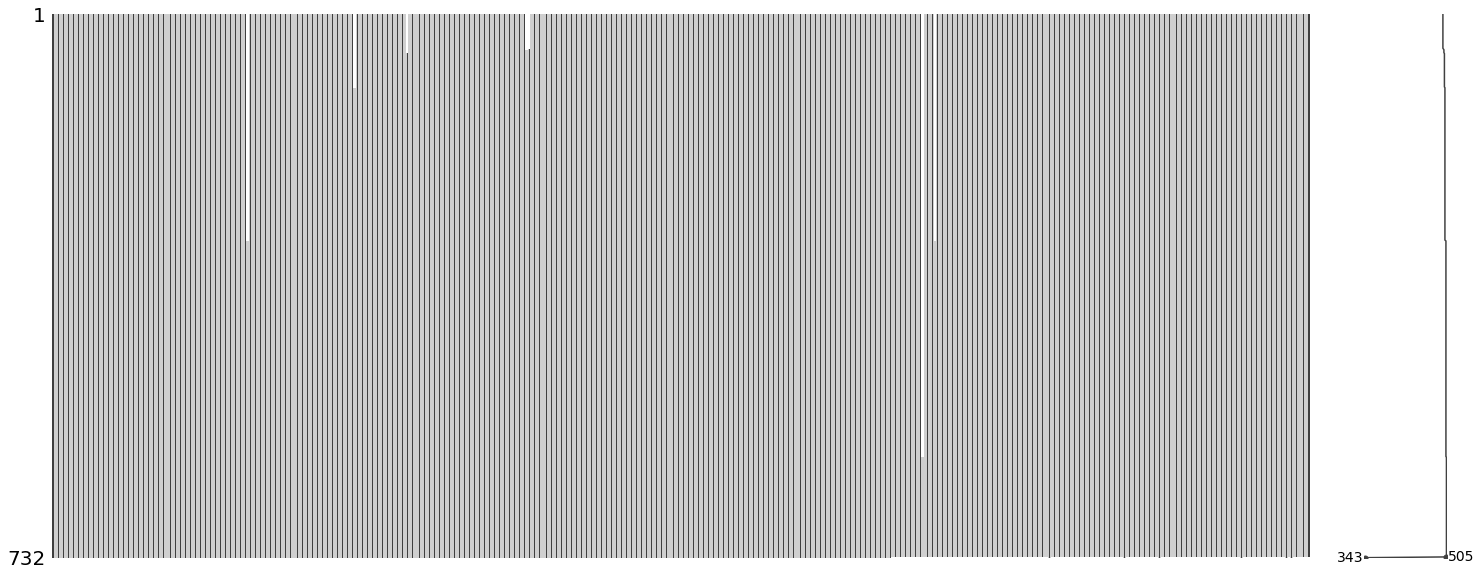

In [14]:
missingno.matrix(data)

In [15]:
print('Data Shape before cleaning =', data.shape)

missing_percentage = data.isnull().mean().sort_values(ascending=False)
missing_percentage.head(10)
dropped_list = sorted(list(missing_percentage[missing_percentage > 0.2].index))
data.drop(labels=dropped_list, axis=1, inplace=True)

print('Data Shape after cleaning =', data.shape)

Data Shape before cleaning = (732, 505)
Data Shape after cleaning = (732, 502)


In [16]:
data = data.fillna(method='ffill')

In [17]:
returns = data.pct_change().mean()*252
returns = pd.DataFrame(returns)
returns.columns = ['returns']

returns['volatility'] = data.pct_change().std()*np.sqrt(252)

data = returns
data.head()

,returns,volatility
ticker,,
A,0.336,0.282
AAL,0.061,0.694
AAP,0.202,0.345
AAPL,0.554,0.342
ABBV,0.193,0.283


In [18]:
scale = StandardScaler().fit(data)
scaled_data = pd.DataFrame(scale.fit_transform(data),columns = data.columns, index = data.index)
X = scaled_data
X.head()

,returns,volatility
ticker,,
A,0.314,-0.891
AAL,-1.295,2.861
AAP,-0.470,-0.322
AAPL,1.586,-0.344
ABBV,-0.525,-0.885


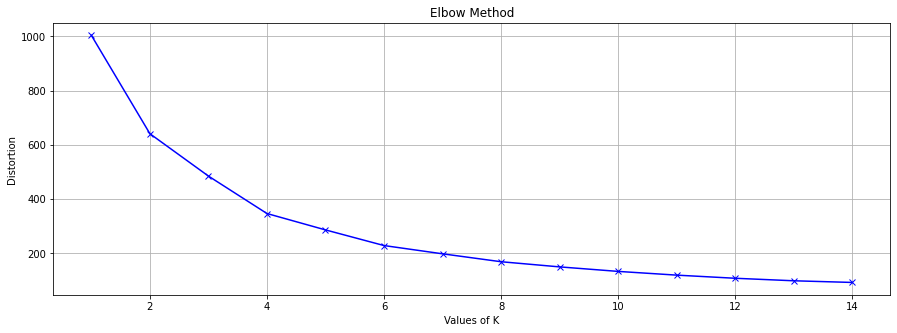

In [19]:
K = range(1,15)
distortions = []

for k in K:
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(X)
    distortions.append(kmeans.inertia_)

fig = plt.figure(figsize= (15,5))
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('Elbow Method')
plt.grid(True)
plt.show()

In [20]:
kl = KneeLocator(K, distortions, curve="convex", direction="decreasing")
kl.elbow

4

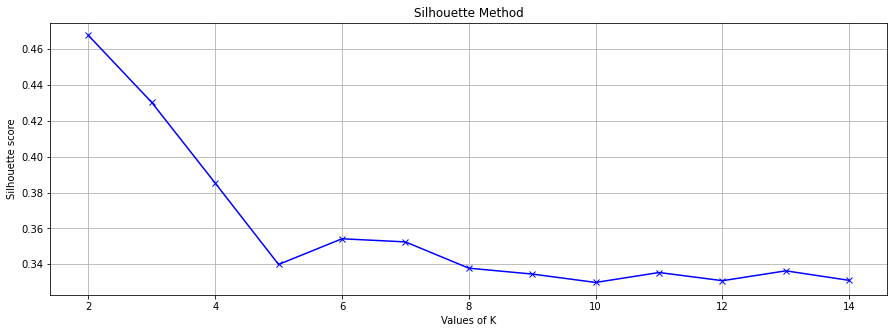

Suggested number of clusters:  5


In [21]:
#For the silhouette method k needs to start from 2
K = range(2,15)
silhouettes = []

#Fit the method
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, init='random')
    kmeans.fit(X)
    silhouettes.append(silhouette_score(X, kmeans.labels_))

#Plot the results
fig = plt.figure(figsize= (15,5))
plt.plot(K, silhouettes, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Silhouette score')
plt.title('Silhouette Method')
plt.grid(True)
plt.show()

kl = KneeLocator(K, silhouettes, curve="convex", direction="decreasing")
print('Suggested number of clusters: ', kl.elbow)

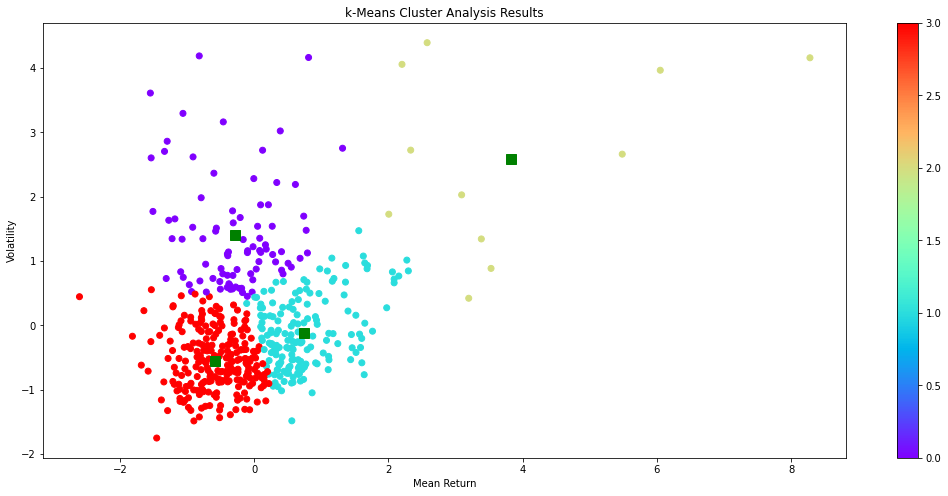

In [42]:
c = 4
#Fit the model
k_means = KMeans(n_clusters=c)
k_means.fit(X)
prediction = k_means.predict(X)

#Plot the results
centroids = k_means.cluster_centers_
fig = plt.figure(figsize = (18,8))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0],X.iloc[:,1], c=k_means.labels_, cmap="rainbow", label = X.index)
ax.set_title('k-Means Cluster Analysis Results')
ax.set_xlabel('Mean Return')
ax.set_ylabel('Volatility')
plt.colorbar(scatter)
plt.plot(centroids[:,0],centroids[:,1],'sg',markersize=10)
plt.show()


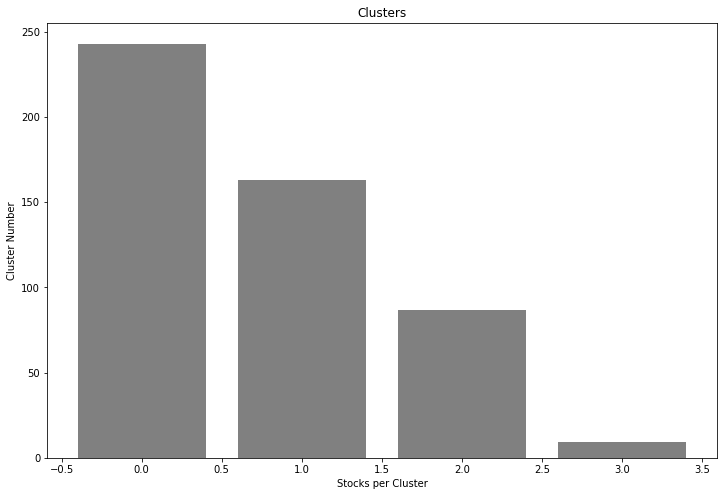

In [23]:
clustered_series = pd.Series(index=X.index, data=k_means.labels_.flatten())
clustered_series_all = pd.Series(index=X.index, data=k_means.labels_.flatten())
clustered_series = clustered_series[clustered_series != -1]
plt.figure(figsize=(12,8))
plt.bar(range(len(clustered_series.value_counts())),clustered_series.value_counts(),color='grey')
plt.title('Clusters')
plt.xlabel('Stocks per Cluster')
plt.ylabel('Cluster Number')
plt.show()

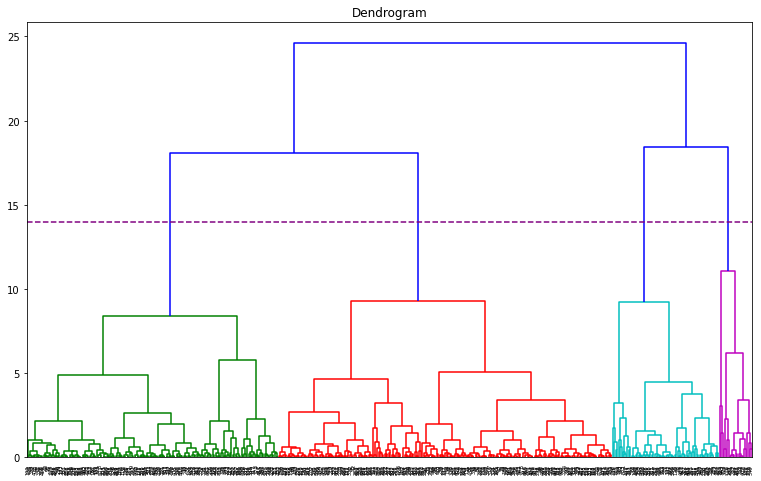

In [24]:
plt.figure(figsize=(13, 8))  
plt.title("Dendrogram")  
dend = shc.dendrogram(shc.linkage(X, method='ward'))
plt.axhline(y=14, color='red', linestyle='--')

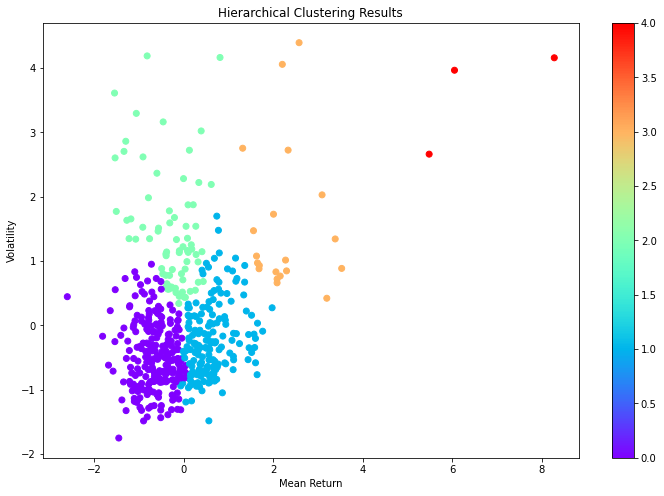

In [43]:
#Fit the model
clusters = 5
hc = AgglomerativeClustering(n_clusters= clusters, affinity='euclidean', linkage='ward')
labels = hc.fit_predict(X)

#Plot the results
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0], X.iloc[:,1], c=labels, cmap='rainbow')
ax.set_title('Hierarchical Clustering Results')
ax.set_xlabel('Mean Return')
ax.set_ylabel('Volatility')
plt.colorbar(scatter)
plt.show()

In [26]:
print("k-Means Clustering average silhouette score", metrics.silhouette_score(X, k_means.labels_, metric='euclidean'))
print("Hierarchical Clustering average silhouette score", metrics.silhouette_score(X, hc.fit_predict(X), metric='euclidean'))

k-Means Clustering average silhouette score 0.38645826556987334
Hierarchical Clustering average silhouette score 0.36298529107085425


In [27]:
data1 = pd.read_csv('S&P500_stock_data')
data1 = data1.fillna(0)
data1.isna().sum()
cluster_size_limit = 1000
counts = clustered_series.value_counts()
ticker_count = counts[(counts>1) & (counts<=cluster_size_limit)]
print ("Number of clusters: %d" % len(ticker_count))
print ("Number of Pairs: %d" % (ticker_count*(ticker_count-1)).sum())

Number of clusters: 4
Number of Pairs: 92766


In [44]:
def find_coint_pairs(data, significance=0.05):
    n = data.shape[1]    
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(1):
        for j in range(i+1, n):
            S1 = data[keys[i]]            
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < significance:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

In [29]:
cluster_dict = {}

for i, clust in enumerate(ticker_count.index):
    tickers = clustered_series[clustered_series == clust].index
    score_matrix, pvalue_matrix, pairs = find_coint_pairs(data1[tickers])
    cluster_dict[clust] = {}
    cluster_dict[clust]['score_matrix'] = score_matrix
    cluster_dict[clust]['pvalue_matrix'] = pvalue_matrix
    cluster_dict[clust]['pairs'] = pairs
    
pairs = []   
for cluster in cluster_dict.keys():
    pairs.extend(cluster_dict[cluster]['pairs'])
    
print ("Number of pairs:", len(pairs))
print ("In those pairs, we found %d unique tickers." % len(np.unique(pairs)))
print(pairs)

Number of pairs: 21
In those pairs, we found 24 unique tickers.
[('AAP', 'AOS'), ('AAP', 'GPC'), ('AAP', 'IRM'), ('AAP', 'JNPR'), ('AAP', 'WAB'), ('A', 'BLK'), ('A', 'CRL'), ('A', 'GNRC'), ('A', 'GOOG'), ('A', 'GOOGL'), ('A', 'GRMN'), ('A', 'ISRG'), ('A', 'LH'), ('A', 'MCK'), ('A', 'MS'), ('AAL', 'BA'), ('AAL', 'CCL'), ('AAL', 'NCLH'), ('AAL', 'OXY'), ('AAL', 'SLB'), ('AAL', 'SPG')]


In [30]:
stocks = np.unique(pairs)
X_data = pd.DataFrame(index=X.index, data=X).T
in_pairs_series = clustered_series.loc[stocks]
stocks = list(np.unique(pairs))
X_pairs = X_data.T.loc[stocks]
X_pairs

,returns,volatility
ticker,,
A,0.314,-0.891
AAL,-1.295,2.861
AAP,-0.470,-0.322
AOS,0.041,-0.625
BA,-1.507,1.771
BLK,0.562,-0.455
CCL,-1.546,3.610
CRL,1.177,-0.128
GNRC,3.198,0.422


In [31]:
X_tsne = TSNE(learning_rate=30, perplexity=5, random_state=42, n_jobs=-1).fit_transform(X_pairs)
X_tsne

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


array([[ -0.81294936, -18.886171  ],
       [-15.711094  ,  14.030647  ],
       [  4.4973164 ,  -1.4908054 ],
       [  7.2442083 ,  -7.902842  ],
       [-12.428318  ,  12.976338  ],
       [  6.0012455 , -17.035675  ],
       [-18.328434  ,  14.718639  ],
       [ 10.905638  , -20.460705  ],
       [ 12.108595  , -23.008512  ],
       [  2.9413748 , -18.52615   ],
       [  3.6906595 , -20.446646  ],
       [  3.9725726 ,  -3.3598995 ],
       [  0.46423772, -20.416567  ],
       [  5.1395245 ,  -5.9654503 ],
       [  5.212453  , -12.384329  ],
       [  7.407988  ,  -0.91573   ],
       [  6.8874717 , -13.781949  ],
       [  6.1018844 , -10.235176  ],
       [ 11.273782  , -18.517616  ],
       [-18.717346  ,  17.30129   ],
       [-16.210806  ,  16.343079  ],
       [-11.16134   ,  11.18529   ],
       [-12.627479  ,   9.764729  ],
       [  1.2411492 ,  -1.379367  ]], dtype=float32)

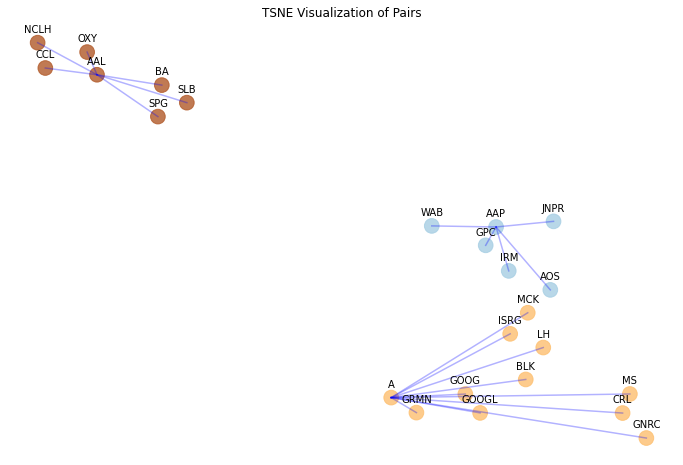

In [32]:
plt.figure(1, facecolor='white',figsize=(12,8))
plt.clf()
plt.axis('off')
for pair in pairs:
    ticker1 = pair[0]
    loc1 = X_pairs.index.get_loc(pair[0])
    x1, y1 = X_tsne[loc1, :]
    ticker2 = pair[0]
    loc2 = X_pairs.index.get_loc(pair[1])
    x2, y2 = X_tsne[loc2, :]
    plt.plot([x1, x2], [y1, y2], 'k-', alpha=0.3, c='b');
    
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=215, alpha=0.8, c=in_pairs_series.values, cmap=cm.Paired)
plt.title('TSNE Visualization of Pairs'); 

# Join pairs by x and y
for x,y,name in zip(X_tsne[:,0],X_tsne[:,1],X_pairs.index):

    label = name

    plt.annotate(label,
                 (x,y),
                 textcoords="offset points",
                 xytext=(0,10),
                 ha='center')
    
plt.show()

In [33]:
data_performance = data_original.pivot(index='date', columns='ticker', values = 'adjclose')
sub_selection = data_performance[['AMD','PAYC']]
sub_selection = (sub_selection.pct_change(1) * 100).dropna()

In [34]:
sub_selection['spread'] = sub_selection['AMD'] - sub_selection['PAYC']
sp500 = si.get_data('SPY', start_date="01/01/2016", index_as_date = False, interval="1d")
sp500.set_index(["date"], inplace = True, drop = True)
sp500_close = sp500['adjclose']
sp500_close = (sp500_close.pct_change(1) * 100).dropna()

In [35]:
dataframe = sub_selection.merge(sp500_close, left_on='date', right_on='date')
dataframe = dataframe.drop(columns=['AMD', 'PAYC'])
dataframe

,spread,adjclose
date,,
2019-01-03,-6.780,-2.386
2019-01-04,7.557,3.350
2019-01-07,5.710,0.788
2019-01-08,-1.566,0.940
2019-01-09,-3.745,0.467
...,...,...
2021-11-17,1.109,-0.243
2021-11-18,4.039,0.340
2021-11-19,0.013,-0.179


In [45]:
print("The Sharpe Ratio of the backtest is: ", empyrical.sharpe_ratio(dataframe['spread']))

The Sharpe Ratio of the backtest is:  0.5296366210510283


In [46]:
start_date = '01/01/2015'
, ('AAL', 'OXY'), ('AAL', 'SLB'), ('AAL', 'VNO')]

def best_sharpe_ratio(df,long,short):
    sub_selection = df[[long,short]]
    sub_selection = (sub_selection.pct_change(1) * 100).dropna()
    sub_selection['spread'] = sub_selection[long] - sub_selection[short]
    print("The Sharpe Ratio of the backtest " + "for " + long + " " + short + " is: ", empyrical.sharpe_ratio(sub_selection['spread']))

In [47]:
best_sharpe_ratio(data_performance,'A', 'ANTM')
best_sharpe_ratio(data_performance,'A', 'CSX')
best_sharpe_ratio(data_performance,'A', 'MCK')
best_sharpe_ratio(data_performance,'A', 'UNH')
best_sharpe_ratio(data_performance,'AAPL', 'ADSK')
best_sharpe_ratio(data_performance,'AAPL', 'ANSS')
best_sharpe_ratio(data_performance,'AAPL', 'BBY')
best_sharpe_ratio(data_performance,'AAPL', 'BIO')
best_sharpe_ratio(data_performance,'AAPL', 'CDAY')
best_sharpe_ratio(data_performance,'AAPL', 'NOW')
best_sharpe_ratio(data_performance,'AAPL', 'ODFL')
best_sharpe_ratio(data_performance,'AAPL', 'TMO')
best_sharpe_ratio(data_performance,'AAL', 'BA')
best_sharpe_ratio(data_performance,'AAL', 'CCL')
best_sharpe_ratio(data_performance,'AAL', 'FANG')
best_sharpe_ratio(data_performance,'AAL', 'FRT')
best_sharpe_ratio(data_performance,'AAL', 'OXY')
best_sharpe_ratio(data_performance,'AAL', 'VNO')

The Sharpe Ratio of the backtest for A ANTM is:  0.21644805420621563
The Sharpe Ratio of the backtest for A CSX is:  0.26526780504042946
The Sharpe Ratio of the backtest for A MCK is:  0.0897261010384995
The Sharpe Ratio of the backtest for A UNH is:  0.18122099310311596
The Sharpe Ratio of the backtest for AAPL ADSK is:  0.7266639279305197
The Sharpe Ratio of the backtest for AAPL ANSS is:  0.5523854786022164
The Sharpe Ratio of the backtest for AAPL BBY is:  0.45019486441013434
The Sharpe Ratio of the backtest for AAPL BIO is:  0.2650083505966918
The Sharpe Ratio of the backtest for AAPL CDAY is:  0.09222344595407068
The Sharpe Ratio of the backtest for AAPL NOW is:  0.09365625297847542
The Sharpe Ratio of the backtest for AAPL ODFL is:  -0.010400483510112364
The Sharpe Ratio of the backtest for AAPL TMO is:  0.47464565708356077
The Sharpe Ratio of the backtest for AAL BA is:  0.06246961120013036
The Sharpe Ratio of the backtest for AAL CCL is:  0.07279430461843682
The Sharpe Ratio o